In [2]:
import torch
import torch.nn as nn    
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torchmetrics.classification import Accuracy 

<p align="center">
  <img src="https://github.com/Achintya47/Fast-Gradient-Sign-Attack/raw/main/cnn2%20.png" alt="CNN Structure" width="600"/>
</p>

<h2 style="color:#2E86C1; font-family:Georgia;" >🧠 Structure of a Convolutional Neural Network</h2>

<p style="font-family:Verdana; font-size:14px; line-height:1.6;">
Convolutional Neural Networks (CNNs) are a class of deep learning models primarily used for analyzing visual imagery. Their architecture mimics the human visual system and consists of several layered components:
</p>

<ul style="font-family:Verdana; font-size:14px;">
  <li><strong style="color:#1ABC9C;">Input Layer:</strong> Accepts raw pixel data (e.g., an RGB image).</li>
  <li><strong style="color:#1ABC9C;">Convolutional Layer:</strong> Applies filters to detect patterns like edges, textures, or shapes.</li>
  <li><strong style="color:#1ABC9C;">Activation Function (ReLU):</strong> Adds non-linearity to help the network learn complex representations.</li>
  <li><strong style="color:#1ABC9C;">Pooling Layer:</strong> Reduces dimensionality by downsampling—commonly using max or average pooling.</li>
  <li><strong style="color:#1ABC9C;">Flatten Layer:</strong> Converts the 2D matrix into a 1D vector for the fully connected layers.</li>
  <li><strong style="color:#1ABC9C;">Fully Connected Layer:</strong> Performs classification by connecting every neuron from the previous layer.</li>
  <li><strong style="color:#1ABC9C;">Output Layer:</strong> Produces final predictions—usually with Softmax for classification tasks.</li>
</ul>

In [3]:
class CNN(nn.Module):
   
    def __init__(self,in_channels : int ,num_classes : int)->None:
        '''
        Building blocks of the convolutional neural network.

        Parameters : 
            in_channels : Number of channels in the input image (1 for gray_scale)
            num_classes : Number of classes to predict. 10 for MNIST
        '''
        super(CNN,self).__init__()
        # 1st Convolutional layer
        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=3,padding=1)
        # Max pooling layer
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        # 2nd Convolutional layer
        self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1)
        # Fully connected layer
        self.fc1=nn.Linear(16*7*7,num_classes)

    def forward(self,x : torch.Tensor) -> torch.Tensor:
        '''
        Define the forward pass of the network.

        Parameters : 
            x : Input tensor of the image to be classified
        
        Returns : 
            The output tensor after passing through the network
        '''
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

In [4]:
def load_mnist(train:bool)->torch.utils.data.DataLoader:
    '''
    A function that loads both , the training and testing data

    Parameters : 
        train : True for getting the training dataset , False for testing dataset
    
    Returns : 
        data_loader : A DataLoader object
    '''
    data_loader=torch.utils.data.DataLoader(
        datasets.MNIST('../data',train=train,download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,)),
                    ])),
                    batch_size=60 ,shuffle=True
    )
    return data_loader

train_loader=load_mnist(train=True)
test_loader=load_mnist(train=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


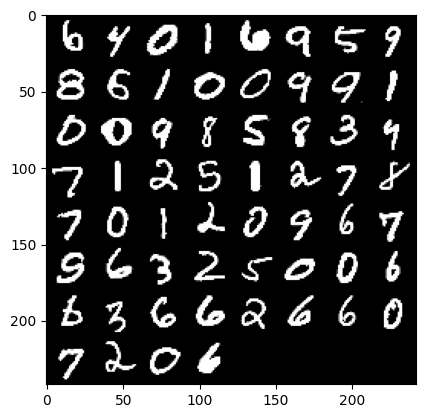

In [5]:
def imshow(img):
   '''
   A function to plot the images for visualising

   Parameters : 
      img : The raw MNIST image
   '''
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

model=CNN(in_channels=1,num_classes=10).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [7]:
# Define the loss function
loss_fn=nn.CrossEntropyLoss()
# Define the Optimizer
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [8]:
num_epochs=10
for epoch in range(num_epochs):
    # Iterate over training batches
     print(f"Epoch [{epoch + 1}/{num_epochs}]")

     for batch_index , (data , targets) in enumerate(tqdm.tqdm(train_loader)):
        # Pushing the data to device , faster computation in case of cuda
        data=data.to(device)
        targets=targets.to(device)
        # Evaluating the model
        scores=model(data)
        loss=loss_fn(scores,targets)
        # Backpropogating and updating the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

Epoch [1/10]


100%|██████████| 1000/1000 [00:34<00:00, 28.59it/s]


Epoch [2/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.10it/s]


Epoch [3/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.98it/s]


Epoch [4/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.35it/s]


Epoch [5/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.69it/s]


Epoch [6/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.22it/s]


Epoch [7/10]


100%|██████████| 1000/1000 [00:35<00:00, 27.96it/s]


Epoch [8/10]


100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s]


Epoch [9/10]


100%|██████████| 1000/1000 [00:37<00:00, 26.92it/s]


Epoch [10/10]


100%|██████████| 1000/1000 [00:36<00:00, 27.76it/s]


In [9]:
acc=Accuracy(task="multiclass",num_classes=10)

model.eval()
with torch.no_grad():
    for images , labels in test_loader:
        # Get predicted probabilities for the test batch
        outputs = model(images)
        _,preds = torch.max(outputs ,1)
        acc(preds,labels)

test_accuracy = acc.compute()
print(f"Test accuracy : {test_accuracy}")

Test accuracy : 0.9882000088691711


In [10]:
def fgsm_attack(image : torch.Tensor,epsilon : float,
               data_grad : torch.Tensor) -> tuple[float , torch.Tensor]:
    '''
    The FGSM attack function

    Parameters : 
        image : A tensor of the image , that will be augmented
        epsilon : The augmentation extent
        data_grad : The gradient of the loss wrt image

    Returns : 
        perturbed_image : The augmented image using FGSM
    '''

    # Obtain the element wise sign of the data gradient
    sign_data_grad=data_grad.sign()
    # Create the perturbed image by adjusting the pixel values
    perturbed_image=image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image=torch.clamp(perturbed_image,0,1)    
    # Return the perturbed image
    return perturbed_image

In [11]:
# Restore tensors to their original scale
def denorm(batch : torch.Tensor , mean=[0.1037] , std=[0.3081]) -> torch.Tensor:
    '''
    Convert a batch of tensors to their original scale

    Parameters : 
        batch : A tensor batch of normalized tensors
        mean : A tensor or a list of mean used for normalization
        std : A tensor or list of standard deviation

    Returns : 
        torch.Tensor : batch of tensors without normalization
    '''

    if isinstance(mean,list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std,list):
        std = torch.tensor(std).to(device)
    
    return batch*std.view(1,-1,1,1) + mean.view(1,-1,1,1)

In [16]:
test_loader=torch.utils.data.DataLoader(
        datasets.MNIST('../data',train=False ,download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,)),
                    ])),
                    batch_size=1 ,shuffle=True
    )

In [17]:
def test_attack( model , device : torch.device , 
                test_loader : torch.utils.data.DataLoader , 
                epsilon : float) -> tuple[torch.Tensor, torch.Tensor]:
    '''
    Testing the model under attack

    Parameters : 
        model : The CNN model to be tested
        device : The device for computations
        test_loader : DataLoader object for test data
        epsilon : The augmentation level , or extent
    
    Returns :
        final_acc : A tensor of the final accuracy of the model
        adv_examples : A few adversarial examples to visualize
    '''

    # Accuracy counter , holding some adv examples and the loss function
    correct=0
    adv_examples=[]
    loss_fn=nn.CrossEntropyLoss()

    # Loop over all the examples in test set
    for data,target in test_loader:
        # Send the data and label to device
        data,target=data.to(device) , target.to(device)
        # Set requires_grad attribute of tensor , for Attack
        data.requires_grad=True
        # Forward pass the data through the model
        output=model(data)
        init_pred=output.max(1,keepdim=True)[1] # Get the index of the max log-prob
       
       # If the model predicted incorrectly , no need to attack
        if init_pred.item() != target.item():
            continue
        # Calculate the loss
        loss=loss_fn(output,target)
        # Zero all existing gradients
        model.zero_grad()
        # Backpropogate the loss , calculate gradients
        loss.backward()
        # Collect datagrad
        data_grad=data.grad.data
        # Denormalize the input image , restore to original scale
        data_denorm=denorm(data)
        # Call FGSM Attack
        perturbed_data=fgsm_attack(data_denorm , epsilon , data_grad)
        # Normalize the attacked image
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
        # Again pass through the model , Re-Classify the preturbed image
        output=model(perturbed_data_normalized)
        # Get the predictions
        final_pred=output.max(1,keepdim=True)[1]

        # Check for successfull classification
        if final_pred.item() == target.item():
            correct +=1
            # Saving zero epsilon examples
            if epsilon ==0 and len(adv_examples) < 5:
                adv_ex=perturbed_data.squeeze().detach().cpu().numpy() 
                adv_examples.append((init_pred.item(),final_pred.item(),adv_ex))

            else : 
                # Saving some adversarial examples
                if len(adv_examples) < 5 :
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))     
    
    # Calculate the final accuracy for this epsilon
    final_acc=correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")
    # Return the accuracy and an adversarial example
    return final_acc , adv_examples

In [18]:
accuracies=[]
examples=[]
epsilons = [0, .05, .1, .15, .2, .25, .3]

for eps in epsilons : 
    acc , ex = test_attack( model , device , test_loader ,eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9874 / 10000 = 0.9874
Epsilon: 0.05	Test Accuracy = 9303 / 10000 = 0.9303
Epsilon: 0.1	Test Accuracy = 7387 / 10000 = 0.7387
Epsilon: 0.15	Test Accuracy = 4532 / 10000 = 0.4532
Epsilon: 0.2	Test Accuracy = 2522 / 10000 = 0.2522
Epsilon: 0.25	Test Accuracy = 1444 / 10000 = 0.1444
Epsilon: 0.3	Test Accuracy = 903 / 10000 = 0.0903


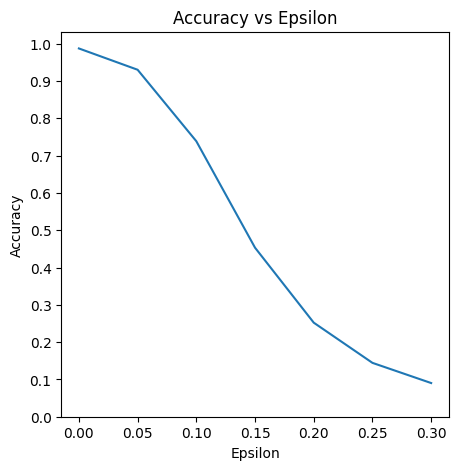

In [19]:
# Plot the accuracies Vs Epsilon graph
plt.figure(figsize=(5,5))
plt.plot(epsilons , accuracies)
plt.yticks(np.arange(0,1.1,step=0.1))
plt.xticks(np.arange(0,0.35,step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

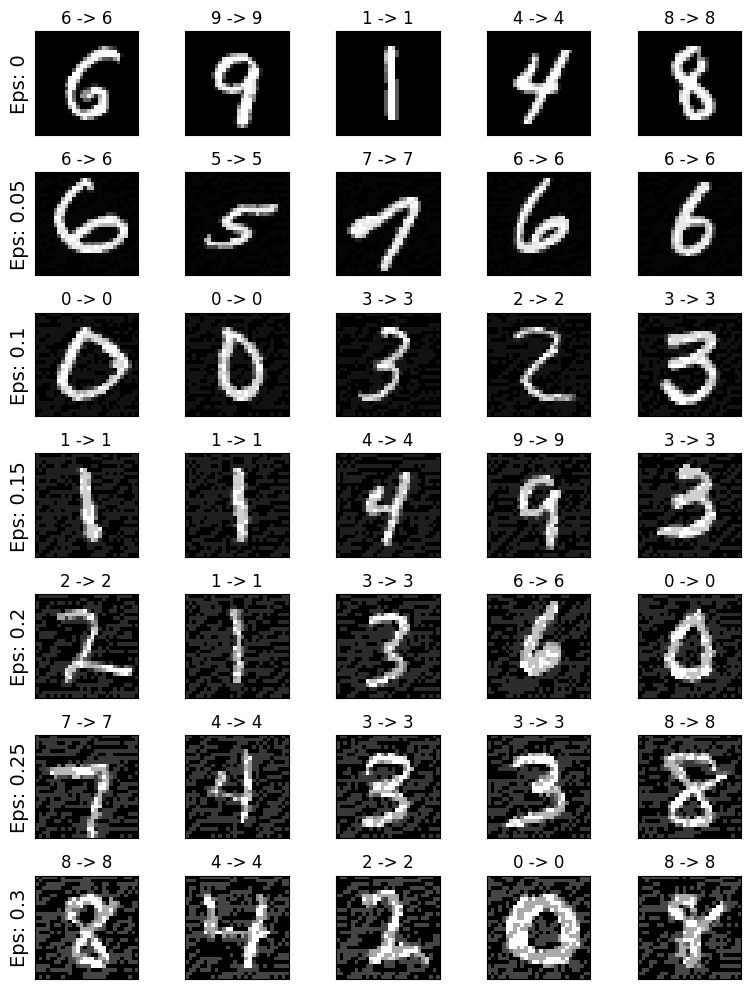

In [20]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()